# Economic Indicators

In this section let's look at economic indicators that could influence price. Here, I compare to the median Lee County and Collier county home prices which is where all the homes are located.

In addition we collected the 30 year fixed mortgage rate in the US which could help calculate cost for our clients.

I also collect S&P500 and Dow Jones price index to understand whether this could infuence mortgage rates. During the COVID Recession (2020) and 2008 stock market crash for instance are memorable times which affected the housing market. We want to see if we are able to forecast potential rates to help consult clients for purchases within the next 30 days.

In [134]:
# Import necessary libararies
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



# Plot Dow Jones & S&P500
Founded this info from https://finance.yahoo.com/ and it's yfinance public API 

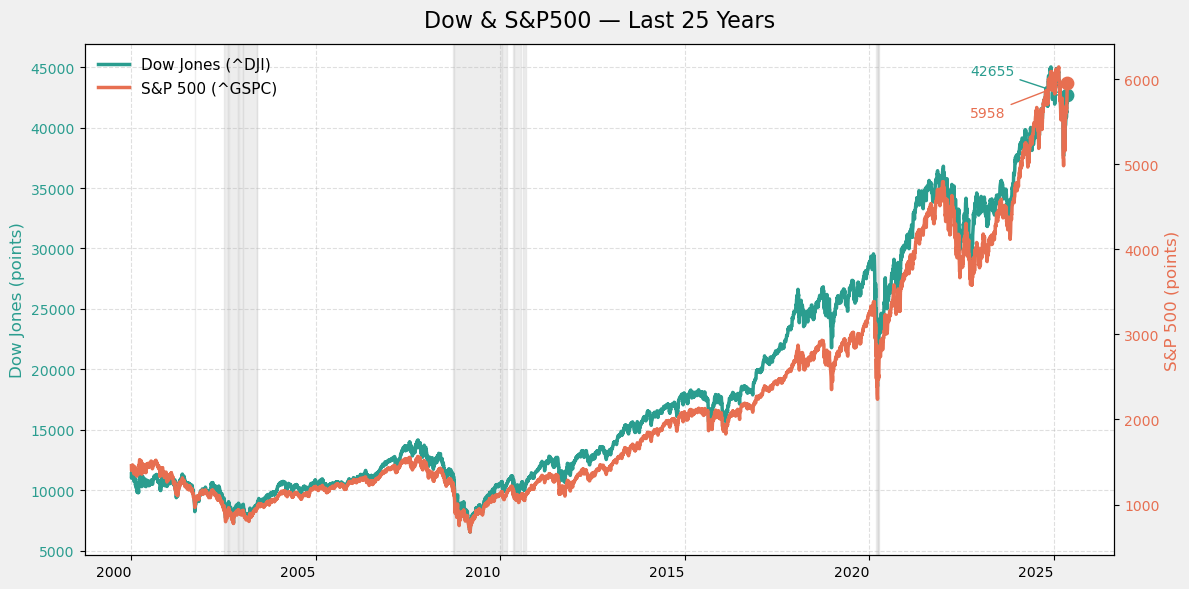

In [140]:


def _get_segments(mask: pd.Series):
    """
    Given a boolean Series indexed by dates, return a list of
    (start_date, end_date) for each contiguous True block.
    """
    segments = []
    in_seg = False
    prev_date = None

    # use .items() instead of .iteritems()
    for date, val in mask.items():
        if val and not in_seg:
            start = date
            in_seg = True
        elif not val and in_seg:
            end = prev_date
            segments.append((start, end))
            in_seg = False
        prev_date = date

    # if still in a segment at the end
    if in_seg:
        segments.append((start, mask.index[-1]))
    return segments

# 1) Download both indices
tickers = ["^DJI", "^GSPC"]
data = yf.download(
    tickers,
    start="2000-01-01",
    end="2025-05-17",          # <- a better coding practice is use TODAY() method since this end date will change
    auto_adjust=False,
    progress=False
)

dj = data["Close"]["^DJI"]
sp = data["Close"]["^GSPC"]

# 2) Compute Dow drawdown mask (>15% off all-time high)
dj_ath  = dj.cummax()
dj_dd   = dj / dj_ath - 1
dd_mask = dj_dd <= -0.25

# 3) Grab latest closes
latest_date = dj.index[-1]
latest_dj   = dj.iloc[-1]
latest_sp   = sp.iloc[-1]

# 4) Plot setup
fig, ax1 = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("#F0F0F0")
ax1.set_facecolor("white")

# 5) Shade drawdown periods
for start, end in _get_segments(dd_mask):
    ax1.axvspan(start, end, color="lightgray", alpha=0.4)

# 6) Plot Dow on left axis
dj_color = "#2A9D8F"
ax1.plot(dj.index, dj, lw=2.5, color=dj_color, label="Dow Jones (^DJI)")
ax1.set_ylabel("Dow Jones (points)", color=dj_color, fontsize=12)
ax1.tick_params(axis="y", labelcolor=dj_color)

# 7) Plot S&P on right axis
ax2 = ax1.twinx()
sp_color = "#E76F51"
ax2.plot(sp.index, sp, lw=2.5, color=sp_color, label="S&P 500 (^GSPC)")
ax2.set_ylabel("S&P 500 (points)", color=sp_color, fontsize=12)
ax2.tick_params(axis="y", labelcolor=sp_color)

# 8) Annotate latest prices
ax1.scatter(latest_date, latest_dj, color=dj_color, s=80, zorder=5)
ax1.annotate(f"{latest_dj:.0f}",
             xy=(latest_date, latest_dj),
             xytext=(-70, 15),
             textcoords="offset points",
             color=dj_color,
             fontsize=10,
             arrowprops=dict(arrowstyle="->", color=dj_color))

ax2.scatter(latest_date, latest_sp, color=sp_color, s=80, zorder=5)
ax2.annotate(f"{latest_sp:.0f}",
             xy=(latest_date, latest_sp),
             xytext=(-70, -25),
             textcoords="offset points",
             color=sp_color,
             fontsize=10,
             arrowprops=dict(arrowstyle="->", color=sp_color))

# 9) X-axis formatting
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax1.get_xticklabels(), rotation=0, ha="right")

# 10) Grid, title, legend
ax1.grid(which="major", linestyle="--", alpha=0.4)
plt.title("Dow & S&P500 — Last 25 Years", fontsize=16, pad=12)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc="upper left", frameon=False, fontsize=11)

plt.tight_layout()
plt.show()


Above is important information. The shaded terms from (2003-2004) (2008-2011) and (2020) are indicators of crashes and even recession

**Background info**: After 9/11 attacks on World Trade Center in New York there was a stock market crash in the months that followed which was a 25% from the current all time high at the time. The Great Recession (2008) also led to devastating impacts as well as the COVID (2020) recession.

Why are stock market crashes important? Well these could be macroeconomic indicators which can influence mortgage rates, and influence housing prices. It's important to know when to buy and when to sell so you don't lose your home like my family did in 2008!

# Plot: Collier vs Lee Home Index Prices & 30 Year Mortgage Rates

These were from the federal reserve which was taken from below
- 30 Year U.S Mortgage Rates: https://fred.stlouisfed.org/series/MORTGAGE30US 
- Collier County Price Index: https://fred.stlouisfed.org/series/ATNHPIUS12021A
- Lee County Price Index: https://fred.stlouisfed.org/series/ATNHPIUS12071A

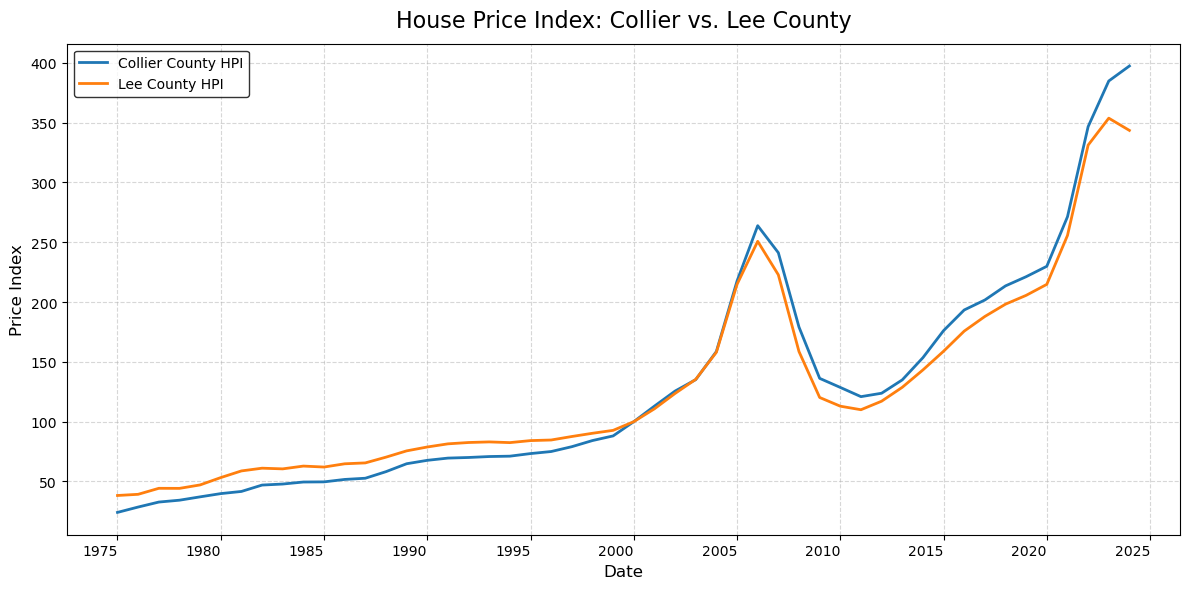

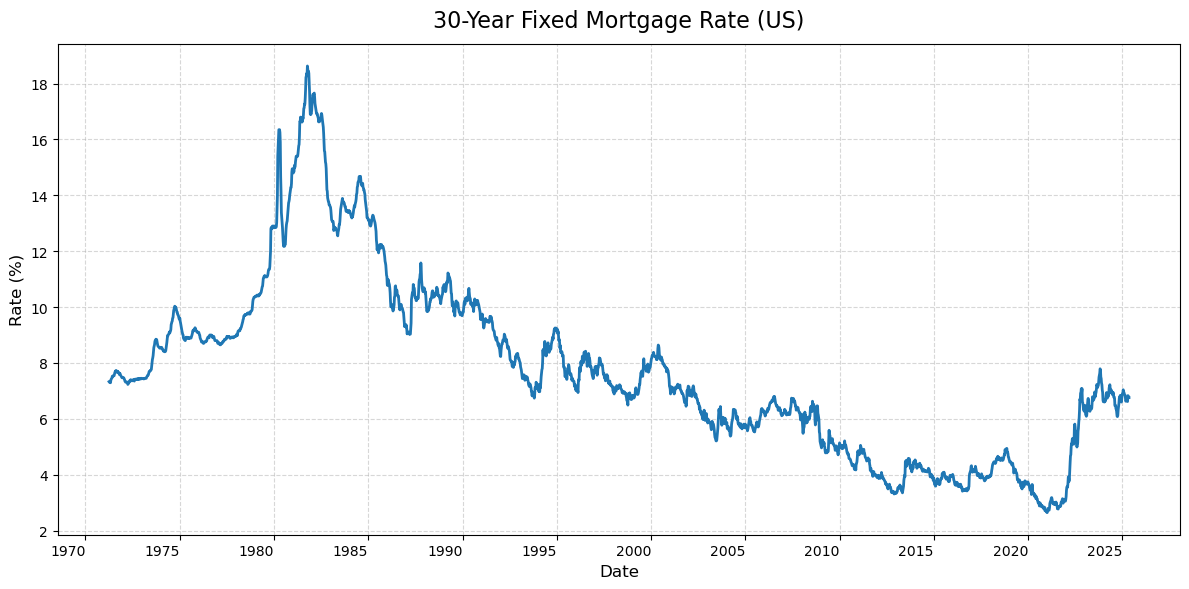

In [57]:


#  Read and prepare Collier & Lee County Price Indices ---
collier = (
    pd.read_csv('Collier_County_Price_Index.csv', parse_dates=['observation_date'])
      .rename(columns={'observation_date': 'Date', 'ATNHPIUS12021A': 'Collier_HPI'})
      .set_index('Date')
)

lee = (
    pd.read_csv('Lee_County_Price_Index.csv', parse_dates=['observation_date'])
      .rename(columns={'observation_date': 'Date', 'ATNHPIUS12071A': 'Lee_HPI'})
      .set_index('Date')
)

# Combine into a single DataFrame
hpi_df = collier.join(lee, how='inner')

# --- Plot Collier vs Lee County HPI ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(hpi_df.index, hpi_df['Collier_HPI'], label='Collier County HPI', linewidth=2)
ax.plot(hpi_df.index, hpi_df['Lee_HPI'],    label='Lee County HPI',      linewidth=2)

# Formatting
ax.set_title('House Price Index: Collier vs. Lee County', fontsize=16, pad=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price Index', fontsize=12)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), ha='right')
ax.grid(which='major', linestyle='--', alpha=0.5)
ax.legend(frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

# --- Read and prepare 30-Year Mortgage Rate ---
mortgage = (
    pd.read_csv('MORTGAGE30US.csv', parse_dates=['observation_date'])
      .rename(columns={'observation_date': 'Date'})
      .set_index('Date')
)

# --- Plot 30-Year Fixed Mortgage Rate ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(mortgage.index, mortgage['MORTGAGE30US'], linewidth=2)

# Formatting
ax.set_title('30-Year Fixed Mortgage Rate (US)', fontsize=16, pad=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rate (%)', fontsize=12)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), ha='right')
ax.grid(which='major', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Time Series Forecasting 
Ensure you load data properly 

C:\Users\chris\AppData\Local\Temp\ipykernel_29568\379422733.py:27: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  mort_annual = mortgage['Mortgage'].resample('AS').mean()
C:\Users\chris\AppData\Local\Temp\ipykernel_29568\379422733.py:32: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df.index = pd.DatetimeIndex(df.index, freq='AS')


ADF Test p-values (maxlag=1):
  Collier: 0.8355
  Lee: 0.5453
  Mortgage: 0.5125

Cointegration p-value (Collier vs Lee): 0.2654

VAR lag order: 1


C:\Users\chris\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\chris\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


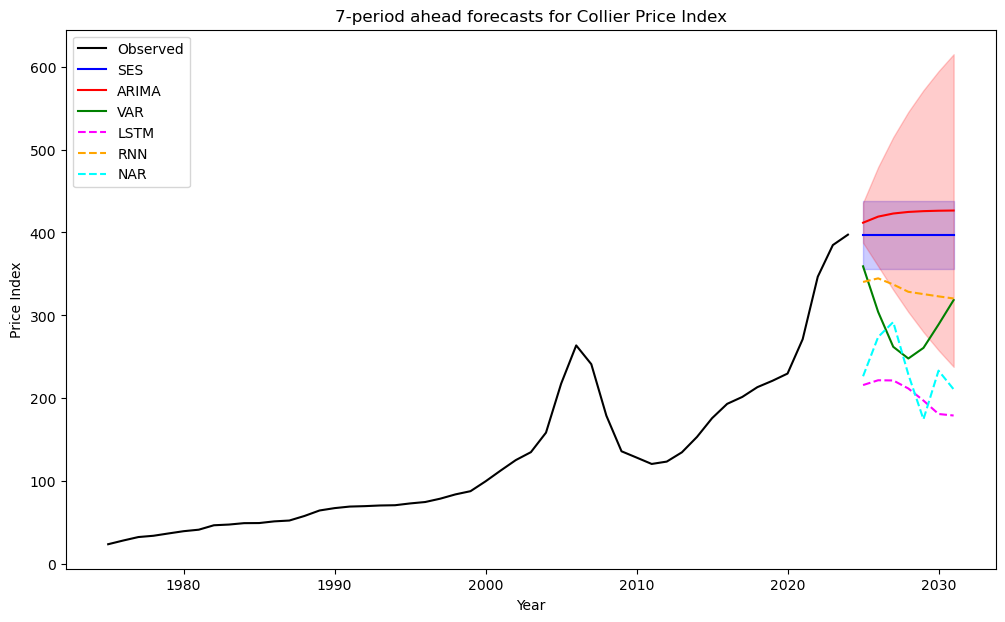

In [61]:


# 1. Load data
collier = pd.read_csv(
    'Collier_County_Price_Index.csv',
    parse_dates=['observation_date'], index_col='observation_date'
).rename(columns={'ATNHPIUS12021A': 'Collier'})

lee = pd.read_csv(
    'Lee_County_Price_Index.csv',
    parse_dates=['observation_date'], index_col='observation_date'
).rename(columns={'ATNHPIUS12071A': 'Lee'})

mortgage = pd.read_csv(
    'MORTGAGE30US.csv',
    parse_dates=['observation_date'], index_col='observation_date'
).rename(columns={'MORTGAGE30US': 'Mortgage'})

# Resample mortgage to annual
mort_annual = mortgage['Mortgage'].resample('AS').mean()

# Combine series
df = collier.join(lee).join(mort_annual).dropna()
df.columns = ['Collier', 'Lee', 'Mortgage']
df.index = pd.DatetimeIndex(df.index, freq='AS')

# 2. Stationarity (ADF maxlag=1)
print("ADF Test p-values (maxlag=1):")
for col in df.columns:
    _, pval, _, _, _, _ = adfuller(df[col], maxlag=1)
    print(f"  {col}: {pval:.4f}")

# 3. Cointegration
_, pvalue, _ = coint(df['Collier'], df['Lee'])
print(f"\nCointegration p-value (Collier vs Lee): {pvalue:.4f}")

# 4. Difference
df_diff = df.diff().dropna()

# 5. VAR on differenced
var_res = VAR(df_diff).fit(maxlags=5, ic='aic')
lags = var_res.k_ar
print(f"\nVAR lag order: {lags}")
h = 7
idx_fut = pd.date_range(df.index[-1] + df.index.freq, periods=h, freq=df.index.freq)
var_fd = var_res.forecast(df_diff.values[-lags:], steps=h)
var_fore = pd.DataFrame(var_fd, index=idx_fut, columns=df_diff.columns).cumsum() + df.iloc[-1]

# 6. ARIMA (no seasonality for annual)
arima = SARIMAX(df['Collier'], order=(1,1,1)).fit(disp=False)
arima_fc = arima.get_forecast(steps=h)
arima_mean = arima_fc.predicted_mean
arima_ci = arima_fc.conf_int()

# 7. SES
ses = SimpleExpSmoothing(df['Collier']).fit(optimized=True)
ses_fc = ses.forecast(h)
sigma = (df['Collier'] - ses.fittedvalues).std()
ses_ci = pd.DataFrame({'lower': ses_fc - 1.96*sigma, 'upper': ses_fc + 1.96*sigma}, index=ses_fc.index)

# 8. Neural Nets (optional)
tf_available = False
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
    tf_available = True
except ImportError:
    print("\nTensorFlow not installed; skipping NN forecasts.")

if tf_available:
    scaler = MinMaxScaler()
    data = scaler.fit_transform(df[['Collier']])
    window = 5
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    X3d = X.reshape((-1, window, 1))

    lstm = Sequential([LSTM(20, input_shape=(window,1)), Dense(1)])
    lstm.compile('adam', 'mse'); lstm.fit(X3d, y, epochs=30, verbose=0)
    rnn = Sequential([SimpleRNN(20, input_shape=(window,1)), Dense(1)])
    rnn.compile('adam', 'mse'); rnn.fit(X3d, y, epochs=30, verbose=0)
    nar = Sequential([Dense(20, activation='relu', input_dim=window), Dense(1)])
    nar.compile('adam', 'mse'); nar.fit(X, y, epochs=30, verbose=0)

    def nn_fore(model):
        seq = data[-window:].copy()
        preds = []
        for _ in range(h):
            inp = seq.reshape((1, window, 1)) if model!=nar else seq.reshape((1, window))
            p = model.predict(inp, verbose=0)[0,0]
            preds.append(p)
            seq = np.append(seq[1:], p)
        return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

    lstm_fc = nn_fore(lstm)
    rnn_fc = nn_fore(rnn)
    nar_fc = nn_fore(nar)
else:
    lstm_fc = rnn_fc = nar_fc = None

# 9. Plot forecasts with shading
plt.figure(figsize=(12,7))
plt.plot(df['Collier'], label='Observed', color='black')
# SES
plt.plot(ses_fc, label='SES', color='blue')
try:
    plt.fill_between(ses_ci.index, ses_ci['lower'], ses_ci['upper'], color='blue', alpha=0.2)
except:
    pass
# ARIMA
plt.plot(arima_mean, label='ARIMA', color='red')
try:
    plt.fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='red', alpha=0.2)
except:
    pass
# VAR
plt.plot(var_fore['Collier'], label='VAR', color='green')
# Neural nets
if tf_available:
    plt.plot(idx_fut, lstm_fc, '--', label='LSTM', color='magenta')
    plt.plot(idx_fut, rnn_fc, '--', label='RNN', color='orange')
    plt.plot(idx_fut, nar_fc, '--', label='NAR', color='cyan')
plt.title('7-period ahead forecasts for Collier Price Index')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.legend()
plt.show()


This goes a decade in advance

ADF Test p-values (maxlag=1):
  - Collier: 0.8355
  - Lee: 0.5453
  - Mortgage: 0.5125

- Cointegration p-value (Collier vs Lee): 0.2654

- VAR lag order: 1

p-values show insignificance
Obviously we can only take this result with a grain of salt. Nonstationary data is harder to predict. Market news and new presidents can impact it so we can't really find this forecast reliable

# Improve our Model

^DJI: ADF p-value = 0.659


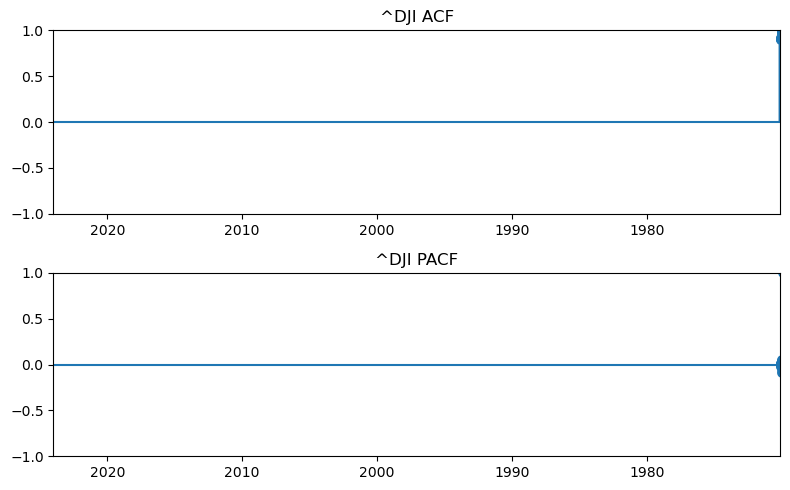

 after 1st‐diff ADF p-value = 0.000


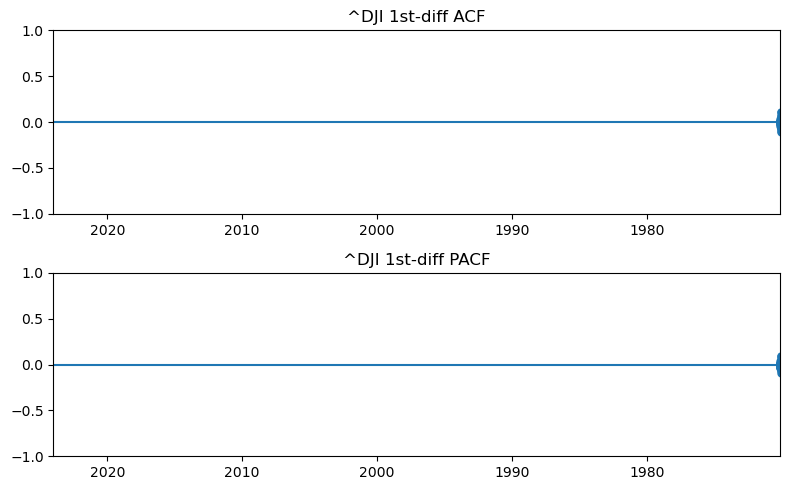

^GSPC: ADF p-value = 0.769


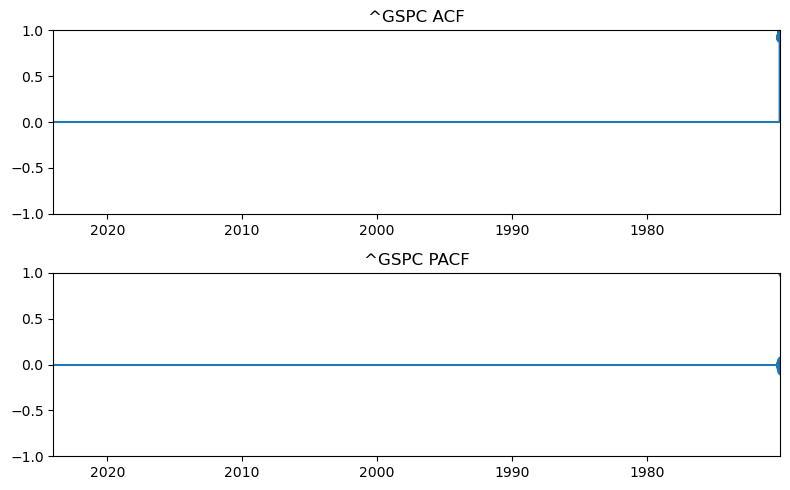

 after 1st‐diff ADF p-value = 0.000


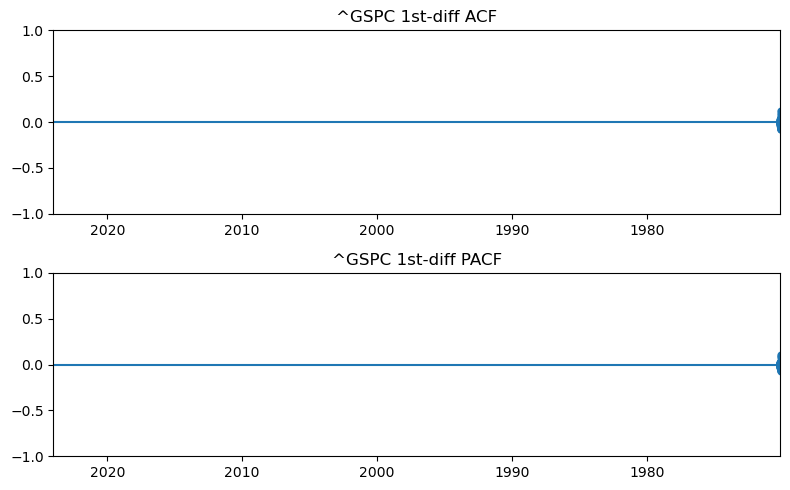

30-Day MAPE (%)
            ^DJI      ^GSPC
Drift  5.090890   7.503764
Holt   8.624383  11.563492
ARIMA  5.150290   7.686528
LSTM   2.185751   2.926594


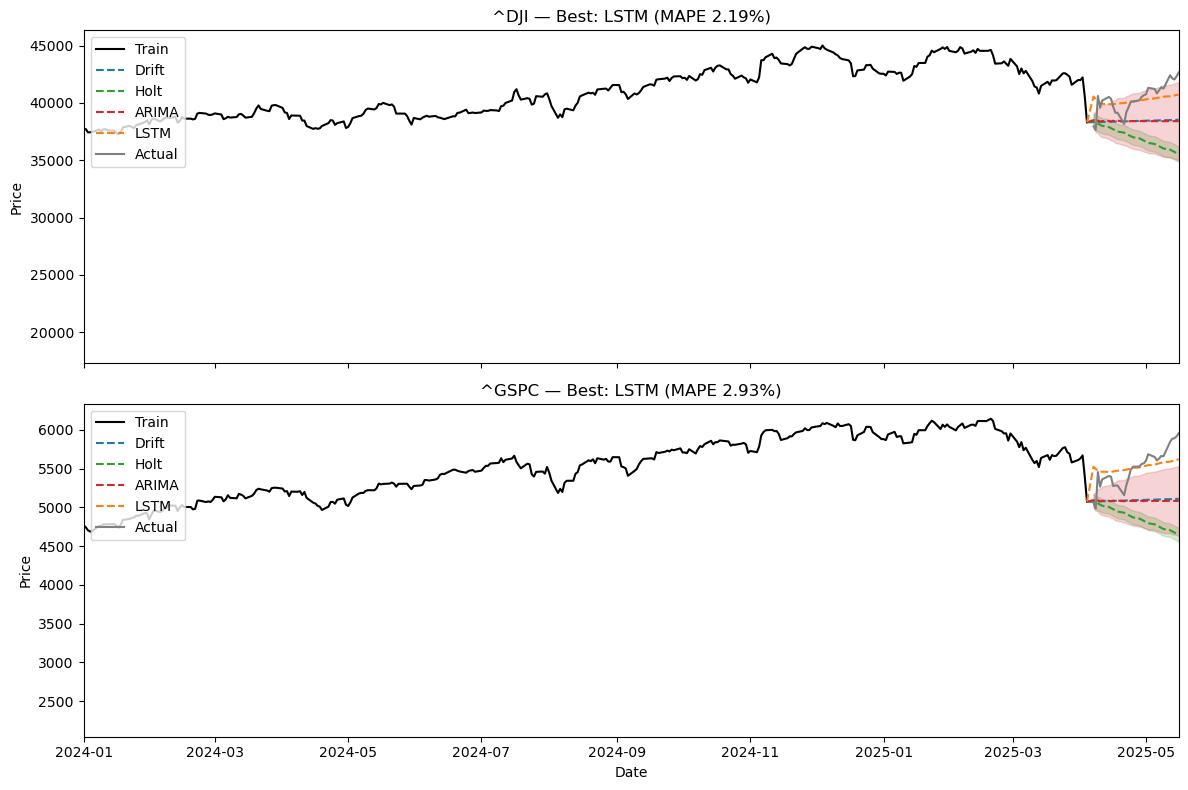

^DJI expected down vs this week's avg (42315.82).
^GSPC expected down vs this week's avg (5899.73).


In [110]:

# 1) Download & clean prices
symbols = ['^DJI', '^GSPC']
raw = yf.download(symbols, start='2018-01-01', progress=False)

# Try selecting 'Adj Close' first, else fall back to 'Close'
if 'Adj Close' in raw.columns:
    data = raw['Adj Close']
elif 'Close' in raw.columns:
    data = raw['Close']
else:
    raise ValueError("Couldn't find 'Adj Close' or 'Close' in columns")

# Ensure business‐day freq and no gaps
data = data.asfreq('B').ffill()

# 2) Train/test split (last 30 business days as test)
h = 30
train = data.iloc[:-h]
test  = data.iloc[-h:]

# 3) Stationarity check + ACF/PACF (zoom from Jan 2024)
start = pd.to_datetime('2024-01-01')
for sym in symbols:
    y = train[sym]
    pval = adfuller(y)[1]
    print(f"{sym}: ADF p-value = {pval:.3f}")
    fig, axes = plt.subplots(2,1,figsize=(8,5))
    plot_acf(y,   ax=axes[0], lags=40, zero=False, title=f"{sym} ACF")
    plot_pacf(y,  ax=axes[1], lags=40, zero=False, title=f"{sym} PACF")
    for ax in axes: ax.set_xlim(start, None)
    plt.tight_layout()
    plt.show()
    if pval > 0.05:
        yd = y.diff().dropna()
        p2 = adfuller(yd)[1]
        print(f" after 1st‐diff ADF p-value = {p2:.3f}")
        fig, axes = plt.subplots(2,1,figsize=(8,5))
        plot_acf(yd,  ax=axes[0], lags=40, zero=False, title=f"{sym} 1st‐diff ACF")
        plot_pacf(yd, ax=axes[1], lags=40, zero=False, title=f"{sym} 1st‐diff PACF")
        for ax in axes: ax.set_xlim(start, None)
        plt.tight_layout()
        plt.show()

# 4) Forecast functions
def drift_forecast(y):
    slope = (y.iloc[-1] - y.iloc[0])/(len(y)-1)
    return pd.Series([y.iloc[-1] + (i+1)*slope for i in range(h)], index=test.index)

def holt_forecast(y):
    res = Holt(y, damped_trend=False).fit(optimized=True)
    return res.forecast(h), res

def arima_forecast(y):
    res = ARIMA(y, order=(2,1,2)).fit()
    fc = res.get_forecast(h)
    return fc.predicted_mean, fc.conf_int(alpha=0.05)

def lstm_forecast(y):
    scaler = MinMaxScaler()
    vs = scaler.fit_transform(y.values.reshape(-1,1))
    p=20; X,Y=[],[]
    for i in range(p,len(vs)):
        X.append(vs[i-p:i,0]); Y.append(vs[i,0])
    X,Y = np.array(X), np.array(Y)
    X3 = X.reshape((-1,p,1))
    m = Sequential([LSTM(50,input_shape=(p,1)),Dense(1)])
    m.compile('adam','mse')
    m.fit(X3, Y, epochs=30, verbose=0)
    seq = vs[-p:,0].copy(); preds=[]
    for _ in range(h):
        yhat = m.predict(seq.reshape(1,p,1), verbose=0)[0,0]
        preds.append(yhat)
        seq = np.append(seq[1:], yhat)
    return pd.Series(scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten(),
                     index=test.index)

# 5) Generate forecasts & compute MAPE
methods = ['Drift','Holt','ARIMA','LSTM']
mape = pd.DataFrame(index=methods, columns=symbols, dtype=float)
forecasts = {}

for sym in symbols:
    y = train[sym]
    # Drift
    fd = drift_forecast(y)
    mape.loc['Drift', sym] = mean_absolute_percentage_error(test[sym], fd)*100
    forecasts[(sym,'Drift')] = (fd, None)
    # Holt
    fh, res_h = holt_forecast(y)
    mape.loc['Holt', sym] = mean_absolute_percentage_error(test[sym], fh)*100
    forecasts[(sym,'Holt')] = (fh, res_h)
    # ARIMA
    fa, ci = arima_forecast(y)
    mape.loc['ARIMA', sym] = mean_absolute_percentage_error(test[sym], fa)*100
    forecasts[(sym,'ARIMA')] = (fa, ci)
    # LSTM
    fl = lstm_forecast(y)
    mape.loc['LSTM', sym] = mean_absolute_percentage_error(test[sym], fl)*100
    forecasts[(sym,'LSTM')] = (fl, None)

print("30-Day MAPE (%)\n", mape)

# 6) Plot (DJI top, GSPC bottom) with best highlight & shading
fig, axes = plt.subplots(2,1,figsize=(12,8), sharex=True)
colors = {'Drift':'tab:blue','Holt':'tab:green','ARIMA':'tab:red','LSTM':'tab:orange'}
start = pd.to_datetime('2024-01-01')

for ax, sym in zip(axes, symbols):
    ax.plot(train[sym], 'k-', label='Train')
    for name in methods:
        fc, obj = forecasts[(sym,name)]
        conn = pd.Series(train[sym].iloc[-1], index=[train.index[-1]])
        full = pd.concat([conn, fc])
        ax.plot(full.index, full.values, '--', color=colors[name], label=name)
        # shading
        if name=='Holt':
            # constant‐sigma bands
            resid = train[sym] - Holt(train[sym]).fit(optimized=True).fittedvalues
            sigma = resid.std()
            lower, upper = fc - 1.96*sigma, fc + 1.96*sigma
            ax.fill_between(fc.index, lower, upper, color=colors[name], alpha=0.2)
        if name=='ARIMA':
            ci = obj
            ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color=colors[name], alpha=0.2)

    ax.plot(test[sym], 'gray', label='Actual')
    best = mape[sym].astype(float).idxmin()
    ax.set_title(f"{sym} — Best: {best} (MAPE {mape.loc[best,sym]:.2f}%)")
    ax.set_xlim(start, test.index[-1]); ax.set_ylabel('Price'); ax.legend(loc='upper left')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

# 7) Up/down verdict vs this week's average
this_week = data.iloc[-5:].mean()
for sym in symbols:
    best_fc, _ = forecasts[(sym, mape[sym].astype(float).idxmin())]
    future_avg = best_fc.mean()
    direction  = "up" if future_avg>this_week[sym] else "down"
    print(f"{sym} expected {direction} vs this week's avg ({this_week[sym]:.2f}).")


# Upcoming week forecast
Mean Absolute Percentage Error is small which is good. P-values are supported after tackling the non stationary data and taking difference


In [132]:
# Here we take upcoming forecast for Collier County, lee County, and Mortgage Rates for the next month. Very little change as expected.

print("\n1-Month Ahead Forecasts for Best Methods:\n")

for name, ser in series_dict.items():
    # Identify the best method by MAPE
    best = mape[name].astype(float).idxmin()
    y = ser  # full monthly series

    if best == 'Holt':
        # Holt’s linear trend
        res = Holt(y, damped_trend=False).fit(optimized=True)
        fc = res.forecast(1).iloc[0]

    elif best == 'Drift':
        # drift forecast
        d = (y.iloc[-1] - y.iloc[0])/(len(y)-1)
        fc = y.iloc[-1] + d

    elif best == 'ARIMA':
        # ARIMA(2,1,2)
        mod = ARIMA(y, order=(2,1,2)).fit()
        pred = mod.get_forecast(1)
        fc = pred.predicted_mean.iloc[0]

    elif best == 'LSTM':
        # LSTM (h=1)
        fc = lstm_fc(y).iloc[0]

    else:
        # fallback to last value
        fc = y.iloc[-1]

    print(f"{name:8s} via {best:6s} → forecast = {fc:.2f}")



1-Month Ahead Forecasts for Best Methods:

Collier  via Drift  → forecast = 404.96
Lee      via SARIMA → forecast = 343.49
Mortgage via HWMul  → forecast = 6.76
